<a href="https://colab.research.google.com/github/rafa-rod/Curso-Introducao-Risco-de-Mercado-em-Python---Financial-Risk-Academy/blob/main/teste_pykan_conformal_prediciton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pykan mapie

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.1/178.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 35.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


checkpoint directory created: ./model
saving model version 0.0



description:   0%|                                                           | 0/20 [00:00<?, ?it/s]
| train_loss: 2.32e-01 | test_loss: 1.40e+00 | reg: 1.19e+01 | :   0%|       | 0/20 [00:02<?, ?it/s]
| train_loss: 2.32e-01 | test_loss: 1.40e+00 | reg: 1.19e+01 | :   5%| | 1/20 [00:02<00:44,  2.32s/i
| train_loss: 2.24e-01 | test_loss: 8.48e-01 | reg: 1.04e+01 | :   5%| | 1/20 [00:03<00:44,  2.32s/i
| train_loss: 2.24e-01 | test_loss: 8.48e-01 | reg: 1.04e+01 | :  10%| | 2/20 [00:03<00:31,  1.76s/i
| train_loss: 2.23e-01 | test_loss: 9.51e-01 | reg: 7.13e+00 | :  10%| | 2/20 [00:04<00:31,  1.76s/i
| train_loss: 2.23e-01 | test_loss: 9.51e-01 | reg: 7.13e+00 | :  15%|▏| 3/20 [00:04<00:22,  1.33s/i
| train_loss: 2.22e-01 | test_loss: 6.93e-01 | reg: 5.12e+00 | :  15%|▏| 3/20 [00:04<00:22,  1.33s/i
| train_loss: 2.22e-01 | test_loss: 6.93e-01 | reg: 5.12e+00 | :  20%|▏| 4/20 [00:04<00:15,  1.01it/
| train_loss: 2.20e-01 | test_loss: 7.43e-01 | reg: 4.41e+00 | :  20%|▏| 4/20 [00:05<00:15

saving model version 0.1
Cobertura empírica: 0.900


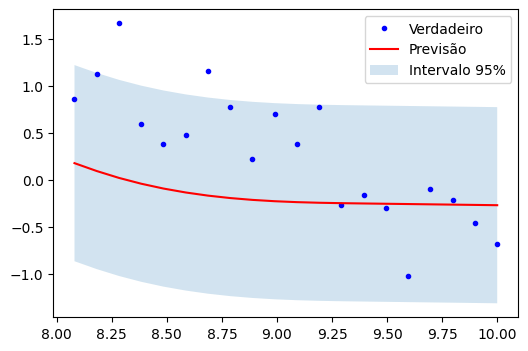

In [ ]:
import numpy as np
import torch
from kan import KAN
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Gerar dados
np.random.seed(42)
t = np.linspace(0, 10, 100)
y = np.sin(t) + np.random.normal(0, 0.1 + 0.05 * t, 100)
X = t.reshape(-1, 1)

# Dividir os dados
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False)
X_calib, X_test, y_calib, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Configurar tensores
train_input = torch.tensor(X_train, dtype=torch.float32)
train_label = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
test_input = torch.tensor(X_calib, dtype=torch.float32)  # Usar X_calib como validação
test_label = torch.tensor(y_calib, dtype=torch.float32).reshape(-1, 1)  # Usar y_calib como validação

# Configurar o modelo PyKAN
model = KAN(width=[1, 5, 1], grid=5, k=3, seed=42)

# Treinar o modelo (incluir dados de validação)
model.fit({
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,  # Adicionado
    'test_label': test_label   # Adicionado
}, opt="LBFGS", steps=20, lamb=0.01)

# Função de predição
def predict_kan(model, X):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    return model(X_tensor).detach().numpy().flatten()

# Weighted conformal prediction
y_pred_calib = predict_kan(model, X_calib)
nonconformity_scores = np.abs(y_calib - y_pred_calib)
lambda_decay = 0.1
t_test = X_test[-1]
t_calib = X_calib.flatten()
weights = np.exp(-lambda_decay * np.abs(t_test - t_calib))
weights = weights / np.sum(weights)
alpha = 0.05
sorted_indices = np.argsort(nonconformity_scores)
sorted_scores = nonconformity_scores[sorted_indices]
sorted_weights = weights[sorted_indices]
cumulative_weights = np.cumsum(sorted_weights)
threshold_idx = np.where(cumulative_weights >= 1 - alpha)[0][0]
tau = sorted_scores[threshold_idx]
y_pred_test = predict_kan(model, X_test)
lower_bound = y_pred_test - tau
upper_bound = y_pred_test + tau

# Avaliar
coverage = np.mean((y_test >= lower_bound) & (y_test <= upper_bound))
print(f"Cobertura empírica: {coverage:.3f}")

# Visualizar
plt.figure(figsize=(6, 4))  # Tamanho otimizado para celular
plt.plot(X_test, y_test, 'b.', label='Verdadeiro')
plt.plot(X_test, y_pred_test, 'r-', label='Previsão')
plt.fill_between(X_test.flatten(), lower_bound, upper_bound, alpha=0.2, label='Intervalo 95%')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import torch
from kan import KAN
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

# Baixar dados reais de PETR4
ticker = ["PETR4.SA"] # Código da Petrobras na B3
data = yf.download(ticker, start="2020-01-01", end="2025-05-11", auto_adjust=True, progress=False)
prices = data['Close'].values  # Preços ajustados de fechamento
dates = data.index  # Datas correspondentes
print(data)
# Criar features temporais (usar índice numérico como proxy de tempo)
t = np.arange(len(prices)).reshape(-1, 1)  # Índice temporal (0, 1, 2, ...)
y = prices  # Preços como variável alvo

# Dividir os dados (respeitando a ordem temporal)
X_train, X_temp, y_train, y_temp = train_test_split(t, y, test_size=0.4, shuffle=False)
X_calib, X_test, y_calib, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Configurar tensores
train_input = torch.tensor(X_train, dtype=torch.float32)
train_label = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
test_input = torch.tensor(X_calib, dtype=torch.float32)  # Validação
test_label = torch.tensor(y_calib, dtype=torch.float32).reshape(-1, 1)  # Validação

# Configurar o modelo PyKAN
model = KAN(width=[1, 5, 1], grid=5, k=3, seed=42)

# Treinar o modelo
model.fit({
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}, opt="LBFGS", steps=20, lamb=0.01)

# Função de predição
def predict_kan(model, X):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    return model(X_tensor).detach().numpy().flatten()

# Weighted conformal prediction
y_pred_calib = predict_kan(model, X_calib)
nonconformity_scores = np.abs(y_calib - y_pred_calib)
lambda_decay = 0.1
t_test = X_test[-1]
t_calib = X_calib.flatten()
weights = np.exp(-lambda_decay * np.abs(t_test - t_calib))
weights = weights / np.sum(weights)
alpha = 0.05  # 95% de confiança
sorted_indices = np.argsort(nonconformity_scores)
sorted_scores = nonconformity_scores[sorted_indices]
sorted_weights = weights[sorted_indices]
cumulative_weights = np.cumsum(sorted_weights)
threshold_idx = np.where(cumulative_weights >= 1 - alpha)[0][0]
tau = sorted_scores[threshold_idx]
y_pred_test = predict_kan(model, X_test)
lower_bound = y_pred_test - tau
upper_bound = y_pred_test + tau

# Avaliar cobertura
coverage = np.mean((y_test >= lower_bound) & (y_test <= upper_bound))
print(f"Cobertura empírica: {coverage:.3f}")

# Visualizar
plt.figure(figsize=(10, 6))  # Ajustado para melhor visualização
plt.plot(dates[X_test.flatten().astype(int)], y_test, 'b.', label='Preço Real (PETR4)')
plt.plot(dates[X_test.flatten().astype(int)], y_pred_test, 'r-', label='Previsão')
plt.fill_between(dates[X_test.flatten().astype(int)], lower_bound, upper_bound, alpha=0.2, label='Intervalo 95%')
plt.xlabel('Data')
plt.ylabel('Preço Ajustado (R$)')
plt.title('Previsão de Preços PETR4 com Intervalos de Confiança')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Salvar o gráfico (opcional para celular)
plt.savefig('petr4_prediction.png')

Price           Close       High        Low       Open    Volume
Ticker       PETR4.SA   PETR4.SA   PETR4.SA   PETR4.SA  PETR4.SA
Date                                                            
2020-01-02   9.959949   9.959949   9.833422   9.898308  37774500
2020-01-03   9.878845  10.135143   9.878845  10.018349  71595600
2020-01-06   9.995638  10.037814   9.716630   9.872355  81844000
2020-01-07   9.956705  10.018346   9.885330   9.998881  32822000
2020-01-08   9.895065   9.982661   9.810714   9.956707  48215600
...               ...        ...        ...        ...       ...
2025-05-05  29.660000  30.620001  29.660000  30.570000  59011700
2025-05-06  30.150000  30.389999  29.959999  30.110001  52751300
2025-05-07  30.290001  30.299999  29.900000  30.299999  35050400
2025-05-08  30.709999  31.030001  30.450001  30.590000  44665000
2025-05-09  30.910000  31.180000  30.639999  31.100000  25075600

[1331 rows x 5 columns]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e+00 | test_loss: 5.75e+00 | reg: 1.64e+01 | : 100%|█| 20/20 [00:11<00:00,  1.71it


saving model version 0.1


ValueError: operands could not be broadcast together with shapes (267,) (266,266) 

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.17e+00 | test_loss: 8.35e+00 | reg: 4.84e+01 | : 100%|█| 20/20 [00:26<00:00,  1.32s/


saving model version 0.1
Shape de y_calib: (266,)
Shape de y_pred_calib: (266,)
Shape de nonconformity_scores: (266,)
Shape de tau: scalar
Shape de y_pred_test: (267,)
Cobertura empírica: 0.899


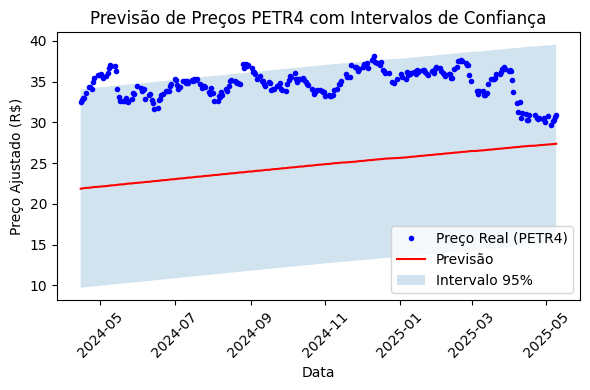

In [ ]:
import numpy as np
import torch
from kan import KAN
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

# Baixar dados reais de PETR4
ticker = "PETR4.SA"
data = yf.download(ticker, start="2020-01-01", end="2025-05-11", progress=False)
prices = data['Close'].values  # Preços ajustados de fechamento
dates = data.index  # Datas correspondentes

# Criar features temporais
t = np.arange(len(prices)).reshape(-1, 1)
y = prices

# Dividir os dados
X_train, X_temp, y_train, y_temp = train_test_split(t, y, test_size=0.4, shuffle=False)
X_calib, X_test, y_calib, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Garantir que y_train, y_calib, y_test sejam 1D
y_train = np.ravel(y_train)
y_calib = np.ravel(y_calib)
y_test = np.ravel(y_test)

# Configurar tensores
train_input = torch.tensor(X_train, dtype=torch.float32)
train_label = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
test_input = torch.tensor(X_calib, dtype=torch.float32)
test_label = torch.tensor(y_calib, dtype=torch.float32).reshape(-1, 1)

# Configurar o modelo PyKAN
model = KAN(width=[1, 30, 1], grid=7, k=3, seed=42)

# Treinar o modelo
model.fit({
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}, opt="LBFGS", steps=20, lamb=0.0)

# Função de predição
def predict_kan(model, X):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    predictions = model(X_tensor).detach().numpy()
    return np.ravel(predictions)  # Garantir 1D

# Weighted conformal prediction
y_pred_calib = predict_kan(model, X_calib)
# Verificar formas
print("Shape de y_calib:", y_calib.shape)
print("Shape de y_pred_calib:", y_pred_calib.shape)
nonconformity_scores = np.abs(y_calib - y_pred_calib)
print("Shape de nonconformity_scores:", nonconformity_scores.shape)

lambda_decay = 0.1
t_test = X_test[-1]
t_calib = X_calib.flatten()
weights = np.exp(-lambda_decay * np.abs(t_test - t_calib))
weights = weights / np.sum(weights)
alpha = 0.05
sorted_indices = np.argsort(nonconformity_scores)
sorted_scores = nonconformity_scores[sorted_indices]
sorted_weights = weights[sorted_indices]
cumulative_weights = np.cumsum(sorted_weights)
threshold_idx = np.where(cumulative_weights >= 1 - alpha)[0][0]
tau = sorted_scores[threshold_idx]
print("Shape de tau:", tau.shape if isinstance(tau, np.ndarray) else "scalar")

y_pred_test = predict_kan(model, X_test)
print("Shape de y_pred_test:", y_pred_test.shape)
lower_bound = y_pred_test - tau
upper_bound = y_pred_test + tau

# Avaliar cobertura
coverage = np.mean((y_test >= lower_bound) & (y_test <= upper_bound))
print(f"Cobertura empírica: {coverage:.3f}")

# Visualizar
plt.figure(figsize=(6, 4))  # Otimizado para celular
plt.plot(dates[X_test.flatten().astype(int)], y_test, 'b.', label='Preço Real (PETR4)')
plt.plot(dates[X_test.flatten().astype(int)], y_pred_test, 'r-', label='Previsão')
plt.fill_between(dates[X_test.flatten().astype(int)], lower_bound, upper_bound, alpha=0.2, label='Intervalo 95%')
plt.xlabel('Data')
plt.ylabel('Preço Ajustado (R$)')
plt.title('Previsão de Preços PETR4 com Intervalos de Confiança')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('petr4_prediction.png')
plt.show()

Shape de prices: (1331,)
Shape de volume: (1331,)
Shapes das colunas do DataFrame:
price: (1331,)
volume: (1331,)
lag_1: (1331,)
lag_2: (1331,)
lag_3: (1331,)
ma_5: (1331,)
ma_20: (1331,)
volatility: (1331,)
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.05e-01 | test_loss: 4.96e-01 | reg: 1.54e+01 | : 100%|█| 50/50 [01:16<00:00,  1.53s/


saving model version 0.1
Cobertura empírica: 0.939
MAE: 0.374 R$


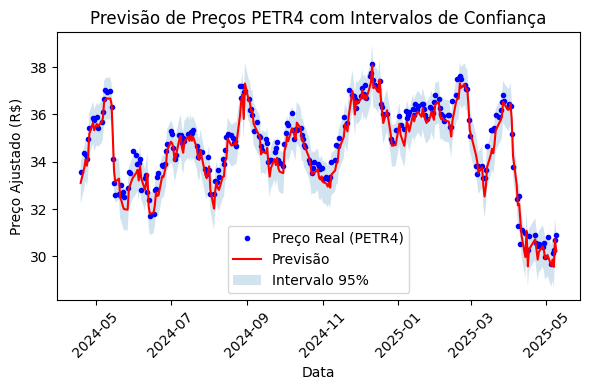

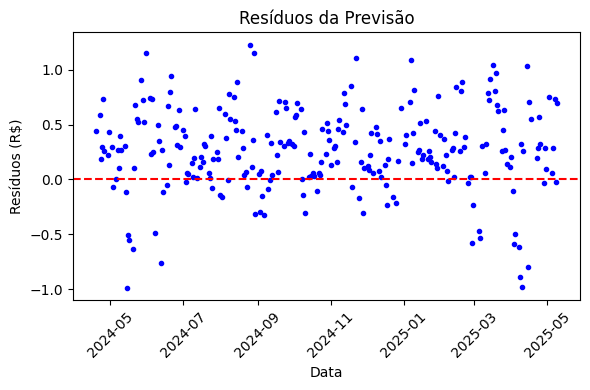

In [ ]:
import numpy as np
import torch
from kan import KAN
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

# Baixar dados reais de PETR4
ticker = "PETR4.SA"
data = yf.download(ticker, start="2020-01-01", end="2025-05-11", progress=False)
prices = data['Close'].values.flatten()  # Garantir 1D
volume = data['Volume'].values.flatten()    # Garantir 1D
dates = data.index

# Criar features
def create_features(prices, volume, n_lags=3, ma_windows=[5, 20]):
    # Garantir que preços e volume sejam 1D
    prices = np.ravel(prices)
    volume = np.ravel(volume)
    print("Shape de prices:", prices.shape)
    print("Shape de volume:", volume.shape)

    df = pd.DataFrame({'price': prices, 'volume': volume})
    # Lagged prices
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df['price'].shift(lag)
    # Moving averages
    for window in ma_windows:
        df[f'ma_{window}'] = df['price'].rolling(window=window).mean()
    # Volatility
    df['volatility'] = df['price'].rolling(window=20).std()
    # Normalize volume
    df['volume'] = df['volume'] / df['volume'].max()
    # Verificar shapes
    print("Shapes das colunas do DataFrame:")
    for col in df.columns:
        print(f"{col}: {df[col].values.shape}")
    # Remover NaNs
    df = df.dropna()
    return df

# Criar dataset
df_features = create_features(prices, volume, n_lags=3, ma_windows=[5, 20])
features = df_features[['lag_1', 'lag_2', 'lag_3', 'ma_5', 'ma_20', 'volatility', 'volume']].values
y = df_features['price'].values
dates = dates[df_features.index]
t = np.arange(len(y)).reshape(-1, 1)

# Dividir os dados
X_train, X_temp, y_train, y_temp, t_train, t_temp = train_test_split(
    features, y, t, test_size=0.4, shuffle=False
)
X_calib, X_test, y_calib, y_test, t_calib, t_test = train_test_split(
    X_temp, y_temp, t_temp, test_size=0.5, shuffle=False
)

# Garantir 1D
y_train = np.ravel(y_train)
y_calib = np.ravel(y_calib)
y_test = np.ravel(y_test)

# Configurar tensores
train_input = torch.tensor(X_train, dtype=torch.float32)
train_label = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
test_input = torch.tensor(X_calib, dtype=torch.float32)
test_label = torch.tensor(y_calib, dtype=torch.float32).reshape(-1, 1)

# Configurar o modelo PyKAN
model = KAN(width=[7, 10, 5, 1], grid=10, k=3, seed=42)

# Treinar o modelo
model.fit({
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}, opt="LBFGS", steps=50, lamb=0.001)

# Função de predição
def predict_kan(model, X):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    predictions = model(X_tensor).detach().numpy()
    return np.ravel(predictions)

# Weighted conformal prediction
y_pred_calib = predict_kan(model, X_calib)
nonconformity_scores = np.abs(y_calib - y_pred_calib)
lambda_decay = 0.1
t_test_last = t_test[-1]
t_calib_flat = t_calib.flatten()
weights = np.exp(-lambda_decay * np.abs(t_test_last - t_calib_flat))
weights = weights / np.sum(weights)
alpha = 0.05
sorted_indices = np.argsort(nonconformity_scores)
sorted_scores = nonconformity_scores[sorted_indices]
sorted_weights = weights[sorted_indices]
cumulative_weights = np.cumsum(sorted_weights)
threshold_idx = np.where(cumulative_weights >= 1 - alpha)[0][0]
tau = sorted_scores[threshold_idx]
y_pred_test = predict_kan(model, X_test)
lower_bound = y_pred_test - tau
upper_bound = y_pred_test + tau

# Avaliar cobertura e MAE
coverage = np.mean((y_test >= lower_bound) & (y_test <= upper_bound))
mae = np.mean(np.abs(y_test - y_pred_test))
print(f"Cobertura empírica: {coverage:.3f}")
print(f"MAE: {mae:.3f} R$")

# Visualizar
plt.figure(figsize=(6, 4))
plt.plot(dates[t_test.flatten().astype(int)], y_test, 'b.', label='Preço Real (PETR4)')
plt.plot(dates[t_test.flatten().astype(int)], y_pred_test, 'r-', label='Previsão')
plt.fill_between(dates[t_test.flatten().astype(int)], lower_bound, upper_bound, alpha=0.2, label='Intervalo 95%')
plt.xlabel('Data')
plt.ylabel('Preço Ajustado (R$)')
plt.title('Previsão de Preços PETR4 com Intervalos de Confiança')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('petr4_prediction.png')
plt.show()

# Plotar resíduos
residuals = y_test - y_pred_test
plt.figure(figsize=(6, 4))
plt.plot(dates[t_test.flatten().astype(int)], residuals, 'b.')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Data')
plt.ylabel('Resíduos (R$)')
plt.title('Resíduos da Previsão')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('petr4_residuals.png')
plt.show()

Shapes das colunas do DataFrame:
price: (798,)
volume: (798,)
lag_1: (798,)
lag_2: (798,)
lag_3: (798,)
ma_5: (798,)
ma_20: (798,)
volatility: (798,)
Shapes das colunas do DataFrame:
price: (266,)
volume: (266,)
lag_1: (266,)
lag_2: (266,)
lag_3: (266,)
ma_5: (266,)
ma_20: (266,)
volatility: (266,)
Shapes das colunas do DataFrame:
price: (267,)
volume: (267,)
lag_1: (267,)
lag_2: (267,)
lag_3: (267,)
ma_5: (267,)
ma_20: (267,)
volatility: (267,)
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.09e-01 | test_loss: 6.26e-01 | reg: 1.60e+01 | : 100%|█| 50/50 [01:17<00:00,  1.55s/


saving model version 0.1
Cobertura empírica: 0.936
MAE: 0.675 R$


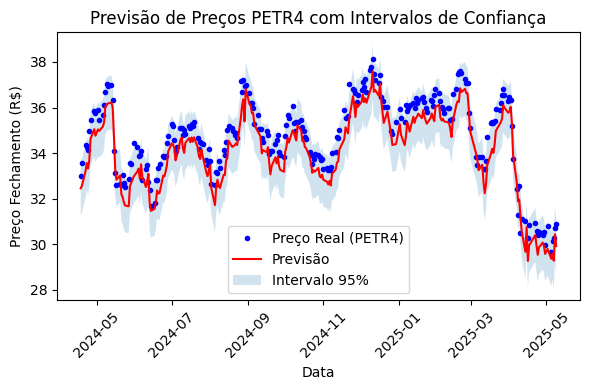

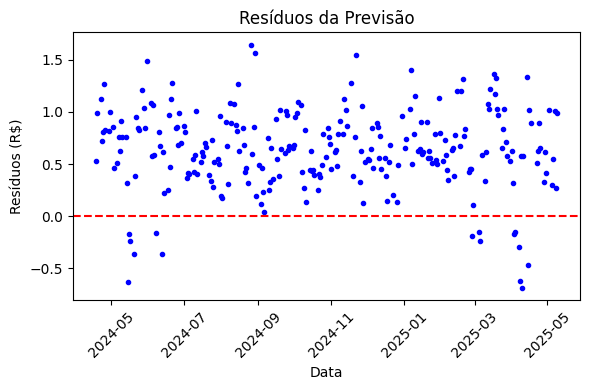

In [ ]:
import numpy as np
import torch
from kan import KAN
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

# Baixar dados reais de PETR4
ticker = "PETR4.SA"
data = yf.download(ticker, start="2020-01-01", end="2025-05-11", progress=False)
prices = data['Close'].values.flatten()  # Usar Close, garantir 1D
volume = data['Volume'].values.flatten()  # Garantir 1D
dates = data.index

# Função para criar features sem leakage
def create_features(prices, volume, n_lags=3, ma_windows=[5, 20], max_volume=None):
    prices = np.ravel(prices)
    volume = np.ravel(volume)
    df = pd.DataFrame({'price': prices, 'volume': volume})

    # Lagged prices
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df['price'].shift(lag)
    # Moving averages
    for window in ma_windows:
        df[f'ma_{window}'] = df['price'].rolling(window=window, min_periods=1).mean()
    # Volatility
    df['volatility'] = df['price'].rolling(window=20, min_periods=1).std()
    # Normalize volume
    if max_volume is None:
        max_volume = df['volume'].max()  # Usar apenas dados disponíveis
    df['volume'] = df['volume'] / max_volume

    # Verificar shapes
    print("Shapes das colunas do DataFrame:")
    for col in df.columns:
        print(f"{col}: {df[col].values.shape}")

    # Remover NaNs
    df = df.dropna()
    return df, max_volume

# Dividir os dados primeiro para evitar leakage
t = np.arange(len(prices)).reshape(-1, 1)
X_train_temp, X_test_temp, y_train, y_test, t_train_temp, t_test = train_test_split(
    t, prices, t, test_size=0.2, shuffle=False
)
X_train, X_calib, y_train, y_calib, t_train, t_calib = train_test_split(
    X_train_temp, y_train, t_train_temp, test_size=0.25, shuffle=False  # 0.25 de 0.8 = 0.2 do total
)

# Garantir 1D
y_train = np.ravel(y_train)
y_calib = np.ravel(y_calib)
y_test = np.ravel(y_test)

# Criar features para cada conjunto separadamente
# Treino
df_train, max_volume = create_features(y_train, volume[t_train.flatten().astype(int)], n_lags=3, ma_windows=[5, 20])
features_train = df_train[['lag_1', 'lag_2', 'lag_3', 'ma_5', 'ma_20', 'volatility', 'volume']].values
t_train = t_train[len(t_train) - len(df_train):]  # Ajustar devido a NaNs

# Calibração
df_calib, _ = create_features(y_calib, volume[t_calib.flatten().astype(int)], n_lags=3, ma_windows=[5, 20], max_volume=max_volume)
features_calib = df_calib[['lag_1', 'lag_2', 'lag_3', 'ma_5', 'ma_20', 'volatility', 'volume']].values
t_calib = t_calib[len(t_calib) - len(df_calib):]

# Teste
df_test, _ = create_features(y_test, volume[t_test.flatten().astype(int)], n_lags=3, ma_windows=[5, 20], max_volume=max_volume)
features_test = df_test[['lag_1', 'lag_2', 'lag_3', 'ma_5', 'ma_20', 'volatility', 'volume']].values
y_test = df_test['price'].values
t_test = t_test[len(t_test) - len(df_test):]

# Configurar tensores
train_input = torch.tensor(features_train, dtype=torch.float32)
train_label = torch.tensor(df_train['price'].values, dtype=torch.float32).reshape(-1, 1)
test_input = torch.tensor(features_calib, dtype=torch.float32)
test_label = torch.tensor(df_calib['price'].values, dtype=torch.float32).reshape(-1, 1)

# Configurar o modelo PyKAN
model = KAN(width=[7, 10, 5, 1], grid=10, k=3, seed=42)

# Treinar o modelo
model.fit({
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}, opt="LBFGS", steps=50, lamb=0.001)

# Função de predição
def predict_kan(model, X):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    predictions = model(X_tensor).detach().numpy()
    return np.ravel(predictions)

# Weighted conformal prediction
y_pred_calib = predict_kan(model, features_calib)
nonconformity_scores = np.abs(df_calib['price'].values - y_pred_calib)
lambda_decay = 0.1
t_test_last = t_test[-1]
t_calib_flat = t_calib.flatten()
weights = np.exp(-lambda_decay * np.abs(t_test_last - t_calib_flat))
weights = weights / np.sum(weights)
alpha = 0.05
sorted_indices = np.argsort(nonconformity_scores)
sorted_scores = nonconformity_scores[sorted_indices]
sorted_weights = weights[sorted_indices]
cumulative_weights = np.cumsum(sorted_weights)
threshold_idx = np.where(cumulative_weights >= 1 - alpha)[0][0]
tau = sorted_scores[threshold_idx]
y_pred_test = predict_kan(model, features_test)
lower_bound = y_pred_test - tau
upper_bound = y_pred_test + tau

# Avaliar cobertura e MAE
coverage = np.mean((y_test >= lower_bound) & (y_test <= upper_bound))
mae = np.mean(np.abs(y_test - y_pred_test))
print(f"Cobertura empírica: {coverage:.3f}")
print(f"MAE: {mae:.3f} R$")

# Visualizar
plt.figure(figsize=(6, 4))
plt.plot(dates[t_test.flatten().astype(int)], y_test, 'b.', label='Preço Real (PETR4)')
plt.plot(dates[t_test.flatten().astype(int)], y_pred_test, 'r-', label='Previsão')
plt.fill_between(dates[t_test.flatten().astype(int)], lower_bound, upper_bound, alpha=0.2, label='Intervalo 95%')
plt.xlabel('Data')
plt.ylabel('Preço Fechamento (R$)')
plt.title('Previsão de Preços PETR4 com Intervalos de Confiança')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('petr4_prediction.png')
plt.show()

# Plotar resíduos
residuals = y_test - y_pred_test
plt.figure(figsize=(6, 4))
plt.plot(dates[t_test.flatten().astype(int)], residuals, 'b.')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Data')
plt.ylabel('Resíduos (R$)')
plt.title('Resíduos da Previsão')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('petr4_residuals.png')
plt.show()

Shape dos retornos: (884, 5)


<ipython-input-18-38f72dbc779c>:35: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist_matrix, method='ward')


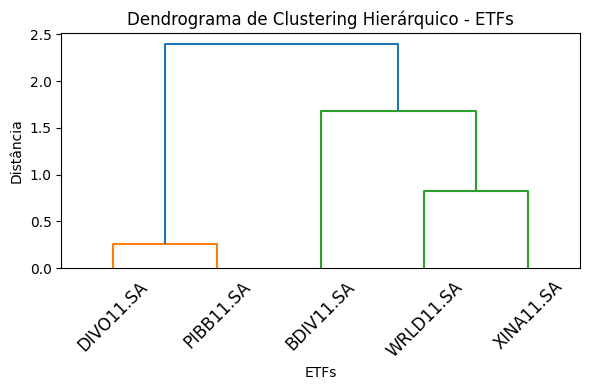

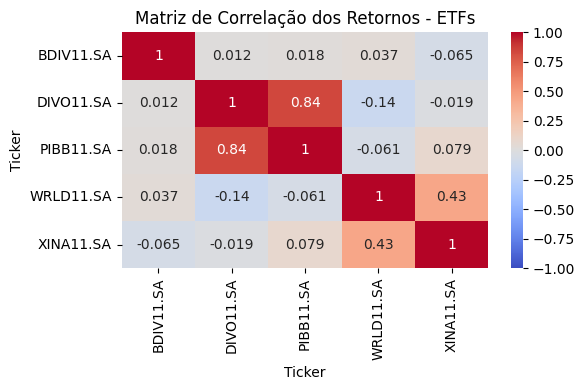

Shapes das colunas do DataFrame:
price: (531,)
volume: (531,)
lag_1: (531,)
lag_2: (531,)
lag_3: (531,)
ma_5: (531,)
ma_20: (531,)
volatility: (531,)
Shapes das colunas do DataFrame:
price: (177,)
volume: (177,)
lag_1: (177,)
lag_2: (177,)
lag_3: (177,)
ma_5: (177,)
ma_20: (177,)
volatility: (177,)
Shapes das colunas do DataFrame:
price: (177,)
volume: (177,)
lag_1: (177,)
lag_2: (177,)
lag_3: (177,)
ma_5: (177,)
ma_20: (177,)
volatility: (177,)
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.32e-01 | test_loss: 4.87e-01 | reg: 2.98e+01 | : 100%|█| 50/50 [01:03<00:00,  1.26s/


saving model version 0.1
Cobertura empírica: 0.948
MAE: 0.475 R$


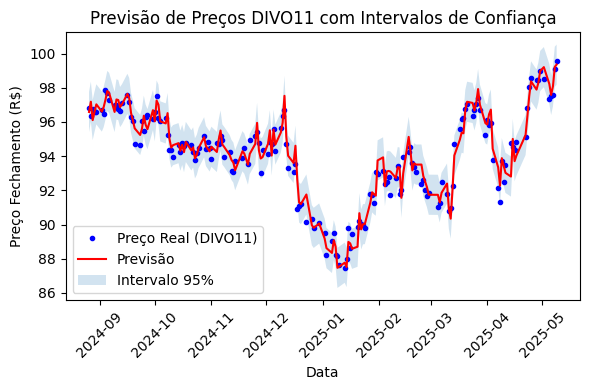

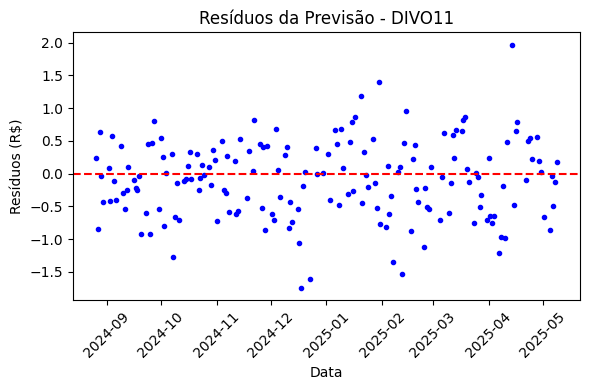

In [ ]:
import numpy as np
import torch
from kan import KAN
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns

# Baixar dados dos ETFs
tickers = ["DIVO11.SA", "PIBB11.SA", "XINA11.SA", "WRLD11.SA", "BDIV11.SA"]
data = yf.download(tickers, start="2020-01-01", end="2025-05-11", progress=False)['Close']
data = data.dropna()  # Remover NaNs
dates = data.index

# Calcular retornos diários
returns = data.pct_change().dropna()
print("Shape dos retornos:", returns.shape)

# Dividir os dados para evitar leakage
train_size = int(0.6 * len(returns))
calib_size = int(0.2 * len(returns))
train_returns = returns.iloc[:train_size]
calib_returns = returns.iloc[train_size:train_size + calib_size]
test_returns = returns.iloc[train_size + calib_size:]
t_train = np.arange(len(train_returns)).reshape(-1, 1)
t_calib = np.arange(len(calib_returns)).reshape(-1, 1)
t_test = np.arange(len(test_returns)).reshape(-1, 1)

# Hierarchical clustering nos retornos de treino
corr_matrix = train_returns.corr()
dist_matrix = 1 - corr_matrix  # Distância = 1 - correlação
dist_matrix = np.clip(dist_matrix, 0, None)  # Garantir não-negatividade
Z = linkage(dist_matrix, method='ward')

# Visualizar dendrograma
plt.figure(figsize=(6, 4))
dendrogram(Z, labels=train_returns.columns, leaf_rotation=45)
plt.title('Dendrograma de Clustering Hierárquico - ETFs')
plt.xlabel('ETFs')
plt.ylabel('Distância')
plt.tight_layout()
plt.savefig('dendrogram.png')
plt.show()

# Visualizar matriz de correlação
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matriz de Correlação dos Retornos - ETFs')
plt.tight_layout()
plt.savefig('corr_heatmap.png')
plt.show()

# Função para criar features sem leakage
def create_features(prices, volume, n_lags=3, ma_windows=[5, 20], max_volume=None):
    prices = np.ravel(prices)
    volume = np.ravel(volume)
    df = pd.DataFrame({'price': prices, 'volume': volume})
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df['price'].shift(lag)
    for window in ma_windows:
        df[f'ma_{window}'] = df['price'].rolling(window=window, min_periods=1).mean()
    df['volatility'] = df['price'].rolling(window=20, min_periods=1).std()
    if max_volume is None:
        max_volume = df['volume'].max()
    df['volume'] = df['volume'] / max_volume
    print("Shapes das colunas do DataFrame:")
    for col in df.columns:
        print(f"{col}: {df[col].values.shape}")
    df = df.dropna()
    return df, max_volume

# Prever retornos do DIVO11
etf = "DIVO11.SA"
prices = data[etf].values
volume = yf.download(etf, start="2020-01-01", end="2025-05-11", progress=False)['Volume'].values
t = np.arange(len(prices)).reshape(-1, 1)

# Dividir dados
X_train_temp, X_test_temp, y_train, y_test, t_train_temp, t_test = train_test_split(
    t, prices, t, test_size=0.2, shuffle=False
)
X_train, X_calib, y_train, y_calib, t_train, t_calib = train_test_split(
    X_train_temp, y_train, t_train_temp, test_size=0.25, shuffle=False
)

# Criar features
df_train, max_volume = create_features(y_train, volume[t_train.flatten().astype(int)])
features_train = df_train[['lag_1', 'lag_2', 'lag_3', 'ma_5', 'ma_20', 'volatility', 'volume']].values
t_train = t_train[len(t_train) - len(df_train):]
df_calib, _ = create_features(y_calib, volume[t_calib.flatten().astype(int)], max_volume=max_volume)
features_calib = df_calib[['lag_1', 'lag_2', 'lag_3', 'ma_5', 'ma_20', 'volatility', 'volume']].values
t_calib = t_calib[len(t_calib) - len(df_calib):]
df_test, _ = create_features(y_test, volume[t_test.flatten().astype(int)], max_volume=max_volume)
features_test = df_test[['lag_1', 'lag_2', 'lag_3', 'ma_5', 'ma_20', 'volatility', 'volume']].values
y_test = df_test['price'].values
t_test = t_test[len(t_test) - len(df_test):]

# Configurar tensores
train_input = torch.tensor(features_train, dtype=torch.float32)
train_label = torch.tensor(df_train['price'].values, dtype=torch.float32).reshape(-1, 1)
test_input = torch.tensor(features_calib, dtype=torch.float32)
test_label = torch.tensor(df_calib['price'].values, dtype=torch.float32).reshape(-1, 1)

# Configurar PyKAN
model = KAN(width=[7, 10, 5, 1], grid=10, k=3, seed=42)
model.fit({
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}, opt="LBFGS", steps=50, lamb=0.001)

# Prever
def predict_kan(model, X):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    return np.ravel(model(X_tensor).detach().numpy())

y_pred_calib = predict_kan(model, features_calib)
nonconformity_scores = np.abs(df_calib['price'].values - y_pred_calib)
lambda_decay = 0.1
t_test_last = t_test[-1]
t_calib_flat = t_calib.flatten()
weights = np.exp(-lambda_decay * np.abs(t_test_last - t_calib_flat))
weights = weights / np.sum(weights)
alpha = 0.05
sorted_indices = np.argsort(nonconformity_scores)
sorted_scores = nonconformity_scores[sorted_indices]
sorted_weights = weights[sorted_indices]
cumulative_weights = np.cumsum(sorted_weights)
threshold_idx = np.where(cumulative_weights >= 1 - alpha)[0][0]
tau = sorted_scores[threshold_idx]
y_pred_test = predict_kan(model, features_test)
lower_bound = y_pred_test - tau
upper_bound = y_pred_test + tau

# Avaliar
coverage = np.mean((y_test >= lower_bound) & (y_test <= upper_bound))
mae = np.mean(np.abs(y_test - y_pred_test))
print(f"Cobertura empírica: {coverage:.3f}")
print(f"MAE: {mae:.3f} R$")

# Visualizar previsão
plt.figure(figsize=(6, 4))
plt.plot(dates[t_test.flatten().astype(int)], y_test, 'b.', label='Preço Real (DIVO11)')
plt.plot(dates[t_test.flatten().astype(int)], y_pred_test, 'r-', label='Previsão')
plt.fill_between(dates[t_test.flatten().astype(int)], lower_bound, upper_bound, alpha=0.2, label='Intervalo 95%')
plt.xlabel('Data')
plt.ylabel('Preço Fechamento (R$)')
plt.title('Previsão de Preços DIVO11 com Intervalos de Confiança')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('divo11_prediction.png')
plt.show()

# Plotar resíduos
residuals = y_test - y_pred_test
plt.figure(figsize=(6, 4))
plt.plot(dates[t_test.flatten().astype(int)], residuals, 'b.')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Data')
plt.ylabel('Resíduos (R$)')
plt.title('Resíduos da Previsão - DIVO11')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('divo11_residuals.png')
plt.show()